This is my first kernel inspired by Chau Ngoc Huynh's kernel (3.699)

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
train = pd.read_csv('../input/train.csv',parse_dates=["first_active_month"])
test = pd.read_csv('../input/test.csv', parse_dates=["first_active_month"])
merchants = pd.read_csv('../input/merchants.csv')

In [5]:
train.shape

(201917, 6)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [7]:
test.shape

(123623, 5)

In [8]:
merchants.shape

(334696, 22)

In [9]:
# Now extract the month, year, day, weekday
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['week'] = train["first_active_month"].dt.weekofyear
train['dayofweek'] = train['first_active_month'].dt.dayofweek
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days

test["month"] = test["first_active_month"].dt.month
test["year"] = test["first_active_month"].dt.year
test['week'] = test["first_active_month"].dt.weekofyear
test['dayofweek'] = test['first_active_month'].dt.dayofweek
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days

Now we will try to extract more features from Transactions Data

In [10]:
# Taking Reference from Other Kernels
def aggregate_transactions(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'merchant_id': ['nunique'],
        'month_lag': ['max','min','mean','var'],
        'month_diff' : ['mean'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique']
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [11]:
transactions = pd.read_csv('../input/historical_transactions.csv')
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})

In [12]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

#impute missing values - This is now excluded.
transactions['category_2'] = transactions['category_2'].fillna(1.0,inplace=True)
transactions['category_3'] = transactions['category_3'].fillna('A',inplace=True)
transactions['merchant_id'] = transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [13]:
agg_func = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    transactions[col+'_mean'] = transactions['purchase_amount'].groupby(transactions[col]).agg(agg_func)

In [14]:
import gc
merge_trans = aggregate_transactions(transactions, prefix='hist_')
del transactions
gc.collect()

train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()


49

In [15]:
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_merchant_id_nunique,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_category_id_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,22,3,245,260,2018-02-25 09:31:15,2017-06-27 14:18:08,9.553846,90,0.346154,247,0.950000,0,0.000000,-165.968739,-0.638341,2.258395,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,0,-8,-3.911538,5.748901,260,9,23,35,7,2,21,41
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,52,6,396,350,2018-01-31 22:31:09,2017-01-06 16:29:42,10.497143,132,0.377143,339,0.968571,31,0.088571,-210.006336,-0.600018,4.630299,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,0,-12,-5.031429,14.477519,350,12,24,50,7,2,24,57


In [16]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9


In [17]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days
test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

In [18]:
# Now extract the data from the new transactions
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv')
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})

In [19]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

#impute missing values
new_transactions['category_2'] = new_transactions['category_2'].fillna(1.0,inplace=True)
new_transactions['category_3'] = new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'] = new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

agg_func = {
        'mean': ['mean'],
    }
for col in ['category_2','category_3']:
    new_transactions[col+'_mean'] = new_transactions['purchase_amount'].groupby(new_transactions[col]).agg(agg_func)

In [20]:
merge_new = aggregate_transactions(new_transactions, prefix='new_')
del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
del merge_new

gc.collect()

21

In [21]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (datetime.datetime.today() - train['new_purchase_date_max']).dt.days
train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (datetime.datetime.today() - test['new_purchase_date_max']).dt.days
test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
#added new feature - Interactive
train['card_id_total'] = train['new_card_id_size'] + train['hist_card_id_size']
train['purchase_amount_total'] = train['new_purchase_amount_sum'] + train['hist_purchase_amount_sum']

test['card_id_total'] = test['new_card_id_size'] + test['hist_card_id_size']
test['purchase_amount_total'] = test['new_purchase_amount_sum'] + test['hist_purchase_amount_sum']

In [22]:
# Now check the shape of Train and Test Data
train.shape

(201917, 87)

In [23]:
test.shape

(123623, 86)

In [24]:
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_merchant_id_nunique,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,...,hist_first_buy,new_transactions_count,new_purchase_date_max,new_purchase_date_min,new_month_diff_mean,new_weekend_sum,new_weekend_mean,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_merchant_id_nunique,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_card_id_size,new_month_nunique,new_hour_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_year_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,22,3,245,260,1.519551e+09,1.498573e+09,9.553846,90,0.346154,247,0.950000,0,0.000000,-165.968739,-0.638341,2.258395,-0.739395,0.212139,4,0.015385,1,0,0.123314,0,0,-8,-3.911538,5.748901,260,9,23,35,...,26,23.0,1.525001e+09,1.520259e+09,9.521739,6.0,0.260870,23.0,1.0,0.0,0.000000,-13.244202,-0.575835,-0.296112,-0.724368,0.135812,0.0,0.000000,0.0,0.0,0.000000,0.0,2.0,1.0,1.478261,0.260870,23.0,2.0,8.0,7.0,7.0,1.0,10.0,14.0,54.0,2.347826,225.0,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,52,6,396,350,1.517438e+09,1.483720e+09,10.497143,132,0.377143,339,0.968571,31,0.088571,-210.006336,-0.600018,4.630299,-0.742400,0.384967,543,1.551429,10,-1,1.510777,0,0,-12,-5.031429,14.477519,350,12,24,50,...,5,6.0,1.522393e+09,1.517505e+09,10.500000,0.0,0.000000,6.0,1.0,0.0,0.000000,-4.355735,-0.725956,-0.701858,-0.739410,0.014326,6.0,1.000000,1.0,1.0,0.000000,0.0,2.0,1.0,1.500000,0.300000,6.0,2.0,5.0,4.0,4.0,1.0,4.0,5.0,56.0,9.333333,255.0,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,31,0,549,43,1.519759e+09,1.484123e+09,9.325581,11,0.255814,41,0.953488,0,0.000000,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,0,0,-13,-8.604651,14.768549,43,10,14,22,...,163,1.0,1.524937e+09,1.524937e+09,9.000000,1.0,1.000000,1.0,1.0,0.0,0.000000,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.000000,0.0,0.0,NaN,0.0,2.0,2.0,2.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,226.0,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,35,4,153,77,1.519818e+09,1.506443e+09,9.428571,11,0.142857,77,1.000000,12,0.155844,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,0,0,-5,-2.831169,3.247437,77,6,16,20,...,25,7.0,1.524049e+09,1.520424e+09,9.571429,3.0,0.428571,7.0,1.0,1.0,0.142857,-4.654372,-0.664910,-0.566740,-0.734135,0.065882,5.0,0.714286,1.0,-1.0,0.755929,0.0,2.0,1.0,1.714286,0.238095,7.0,2.0,5.0,5.0,4.0,1.0,5.0,6.0,41.0,5.857143,236.0,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,44,2,92,133,1.519850e+09,1.510445e+09,9.466165,42,0.315789,128,0.962406,15,0.112782,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,0,0,-3,-1.285714,1.054113,133,4,22,17,...,11,36.0,1.524941e+09,1.519992e+09,9.583333,12.0,0.333333,36.0,1.0,2.0,0.055556,-19.926237,-0.553507,0.450886,-0.739395,

Imputations and Data Transformation

In [25]:
#Check for missing values in training set
nulls = np.sum(train.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = train.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
#print(info)
#print("There are", len(nullcols), "columns with missing values in data set")

In [26]:
#Check for missing values in training set
nulls = np.sum(test.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
#print(info)
#print("There are", len(nullcols), "columns with missing values in test set")

Impute any values will significantly affect the RMSE score for test set. So Imputations have been excluded

In [27]:
numeric_dtypes = ['float64']
numerics = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
#train.update(train[numerics].fillna(0))

In [28]:
numeric_dtypes = ['float64']
numerics = []
for i in test.columns:
    if test[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
#test.update(test[numerics].fillna(0))

Detect and Correct Outliers

In [29]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [30]:
for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [31]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train['target']

Apply Light GBM Modelling Technique

In [32]:
import lightgbm as lgb

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1127]	training's rmse: 3.36187	valid_1's rmse: 3.65643
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1054]	training's rmse: 3.36786	valid_1's rmse: 3.65525
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1325]	training's rmse: 3.32669	valid_1's rmse: 3.65745
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1019]	training's rmse: 3.37245	valid_1's rmse: 3.6589
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1096]	training's rmse: 3.35828	valid_1's rmse: 3.65149


3.6559049299525697

Feature Importance


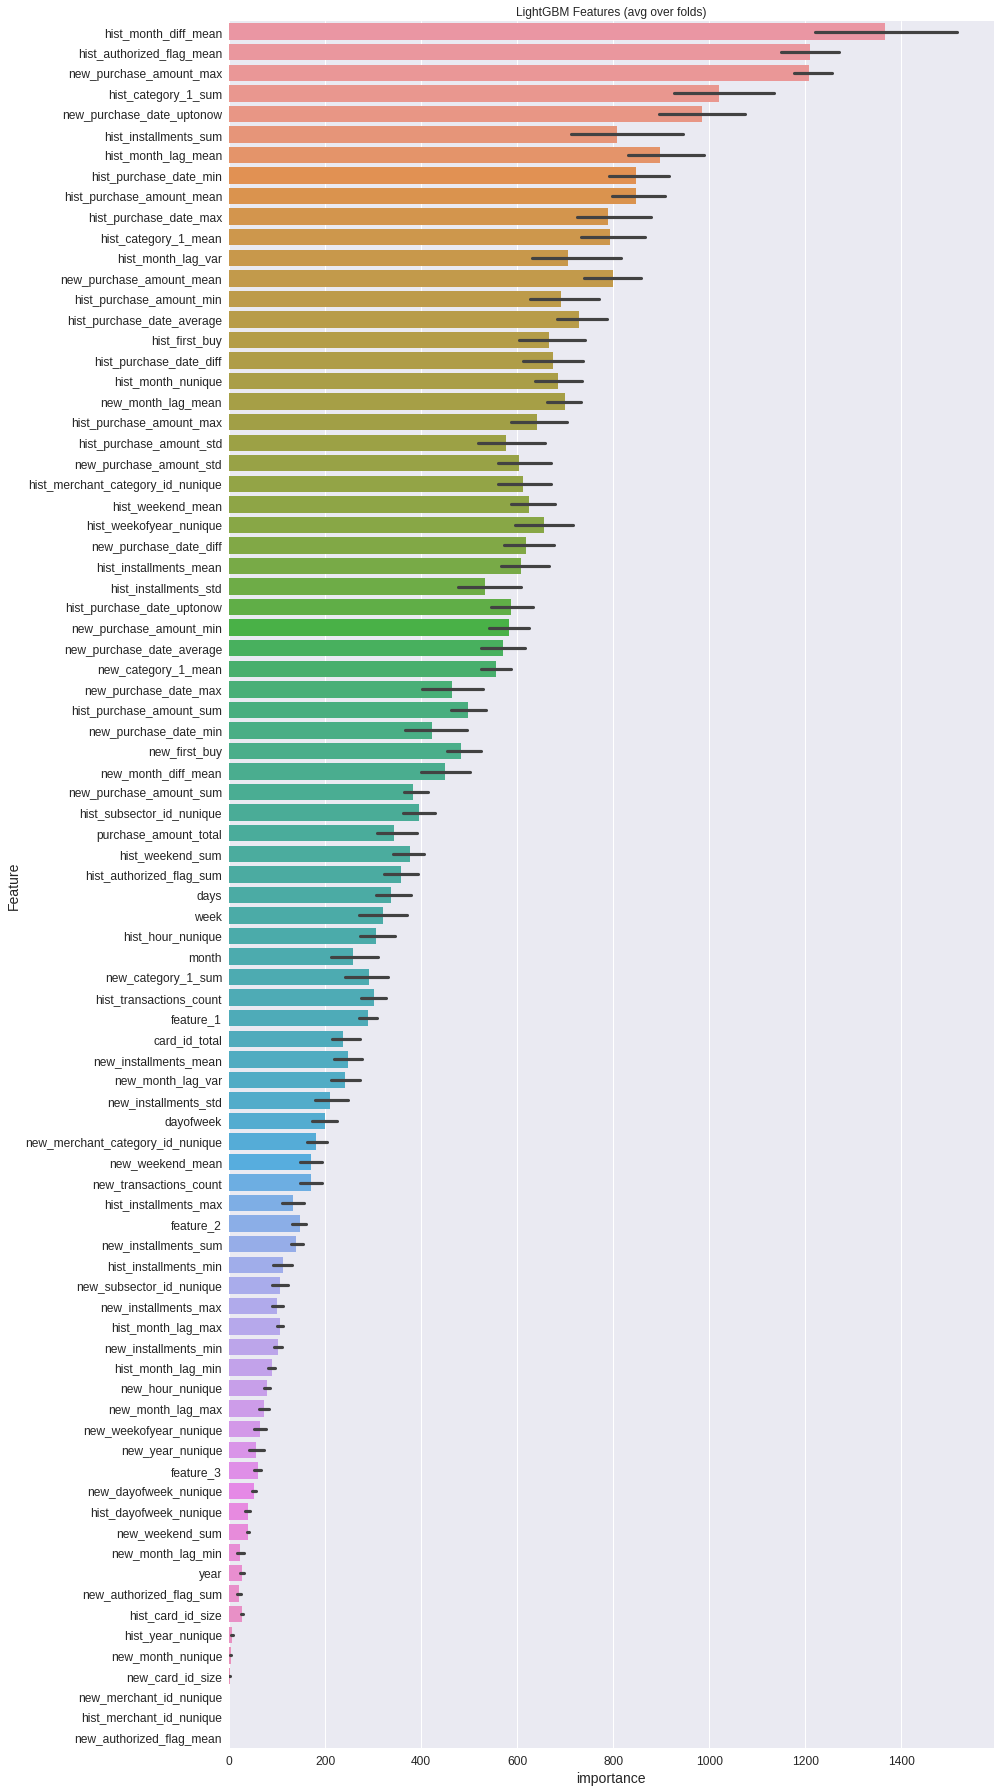

In [33]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

Final Predictions and Submission File.

In [34]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions
sample_submission.to_csv('submission_ashish_lgbm.csv', index=False)